# scratch work

In [2]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial
from tqdm import tqdm


from decimal import Decimal, getcontext

getcontext().prec = 50


import mpmath

mpmath.mp.dps = 75

from jorbit.integrators import initialize_ias15_integrator_state
from jorbit.integrators.ias15 import ias15_step
from jorbit.utils.states import SystemState


from jorbit.utils.doubledouble import DoubleDouble, dd_sum, dd_sqrt, dd_max, dd_norm
from jorbit.utils.generate_coefficients import create_iasnn_constants
from jorbit.data.constants import IAS15_D, IAS15_H, IAS15_RR, IAS15_C
from jorbit.integrators.ias15_dd import setup_iasnn_integrator, step, _refine_b_and_g

In [9]:
precompued_setup_7 = setup_iasnn_integrator(n_internal_points=7)
precompued_setup_10 = setup_iasnn_integrator(n_internal_points=10)

n_orbits = 500

errs_7 = []
errs_10 = []
errs_old = []
for steps_per_orbit in [100]:
    steps_per_orbit = int(steps_per_orbit)

    x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
    v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
    b = DoubleDouble(jnp.zeros((7, 1, 3), dtype=jnp.float64))
    dt = DoubleDouble.from_string(
        str(mpmath.mpf("2") * mpmath.pi / mpmath.mpf(str(steps_per_orbit)))
    )

    for i in tqdm(range(int(steps_per_orbit * n_orbits))):
        x0, v0, b = step(x0, v0, b, dt, precompued_setup_7)
    errs_7.append(dd_norm(DoubleDouble(jnp.array([[1.0, 0, 0]])) - x0, axis=1))

    x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
    v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
    b = DoubleDouble(jnp.zeros((10, 1, 3), dtype=jnp.float64))
    dt = DoubleDouble.from_string(
        str(mpmath.mpf("2") * mpmath.pi / mpmath.mpf(str(steps_per_orbit)))
    )

    for i in tqdm(range(int(steps_per_orbit * n_orbits))):
        x0, v0, b = step(x0, v0, b, dt, precompued_setup_10)
    errs_10.append(dd_norm(DoubleDouble(jnp.array([[1.0, 0, 0]])) - x0, axis=1))

    s = SystemState(
        massive_positions=jnp.empty((0, 3)),
        massive_velocities=jnp.empty((0, 3)),
        tracer_positions=jnp.array([[1.0, 0, 0]]),
        tracer_velocities=jnp.array([[0, 1.0, 0]]),
        log_gms=jnp.empty((0, 1)),
        time=0.0,
        acceleration_func_kwargs=None,
    )
    acceleration_func = (
        lambda s: -s.tracer_positions / jnp.linalg.norm(s.tracer_positions) ** 3
    )
    acceleration_func = jax.tree_util.Partial(acceleration_func)
    a0 = acceleration_func(s)
    ias15_state = initialize_ias15_integrator_state(a0)
    ias15_state.dt = float(2 * mpmath.pi / steps_per_orbit)

    for i in tqdm(range(steps_per_orbit * n_orbits)):
        s, ias15_state = ias15_step(s, acceleration_func, ias15_state)
        ias15_state.dt = float(2 * mpmath.pi / steps_per_orbit)

    errs_old.append(
        jnp.linalg.norm(s.tracer_positions - jnp.array([[1.0, 0, 0]]), axis=1)
    )

100%|██████████| 50000/50000 [00:10<00:00, 4626.03it/s]


In [10]:
errs_7, errs_10, errs_old

([DoubleDouble([9.13533848e-14], [3.21262053e-30])],
 [DoubleDouble([1.21142096e-13], [1.4754822e-30])],
 [Array([7.11460062e-11], dtype=float64)])

In [3]:
precompued_setup_7 = setup_iasnn_integrator(n_internal_points=7)
precompued_setup_10 = setup_iasnn_integrator(n_internal_points=10)

n_orbits = 500

errs_7 = []
errs_10 = []
errs_old = []
for steps_per_orbit in jnp.logspace(0, 3, 20):
    steps_per_orbit = int(steps_per_orbit)

    x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
    v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
    b = DoubleDouble(jnp.zeros((7, 1, 3), dtype=jnp.float64))
    dt = DoubleDouble.from_string(str((2 * mpmath.pi) / steps_per_orbit))

    for i in tqdm(range(int(steps_per_orbit * n_orbits))):
        x0, v0, b = step(x0, v0, b, dt, precompued_setup_7)
    errs_7.append(dd_norm(DoubleDouble(jnp.array([[1.0, 0, 0]])) - x0, axis=1))

    x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
    v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
    b = DoubleDouble(jnp.zeros((10, 1, 3), dtype=jnp.float64))
    dt = DoubleDouble.from_string(str((2 * mpmath.pi + 0.0) / steps_per_orbit))

    for i in tqdm(range(int(steps_per_orbit * n_orbits))):
        x0, v0, b = step(x0, v0, b, dt, precompued_setup_10)
    errs_10.append(dd_norm(DoubleDouble(jnp.array([[1.0, 0, 0]])) - x0, axis=1))

    s = SystemState(
        massive_positions=jnp.empty((0, 3)),
        massive_velocities=jnp.empty((0, 3)),
        tracer_positions=jnp.array([[1.0, 0, 0]]),
        tracer_velocities=jnp.array([[0, 1.0, 0]]),
        log_gms=jnp.empty((0, 1)),
        time=0.0,
        acceleration_func_kwargs=None,
    )
    acceleration_func = (
        lambda s: -s.tracer_positions / jnp.linalg.norm(s.tracer_positions) ** 3
    )
    acceleration_func = jax.tree_util.Partial(acceleration_func)
    a0 = acceleration_func(s)
    ias15_state = initialize_ias15_integrator_state(a0)
    ias15_state.dt = float(2 * mpmath.pi / steps_per_orbit)

    for i in tqdm(range(steps_per_orbit * n_orbits)):
        s, ias15_state = ias15_step(s, acceleration_func, ias15_state)
        ias15_state.dt = float(2 * mpmath.pi / steps_per_orbit)

    errs_old.append(
        jnp.linalg.norm(s.tracer_positions - jnp.array([[1.0, 0, 0]]), axis=1)
    )

100%|██████████| 500000/500000 [01:27<00:00, 5716.21it/s]


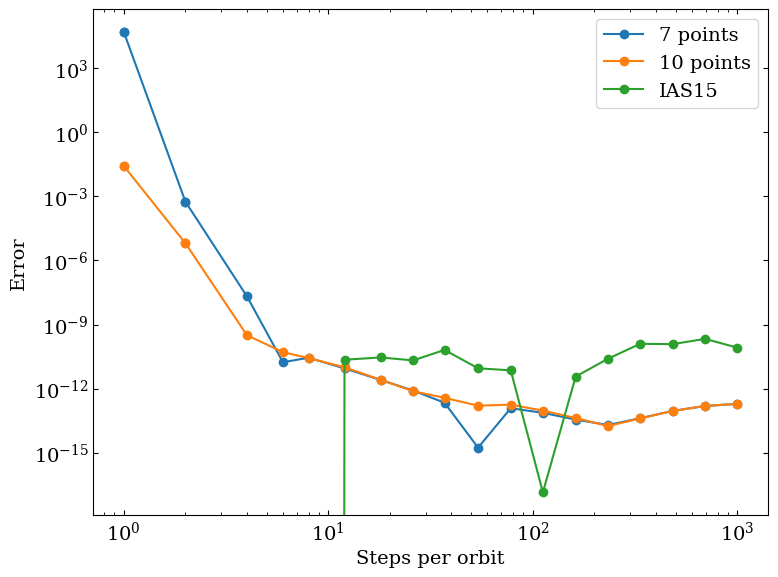

In [ ]:
# ah, I bet all the large steps were rejected by the IAS15 integrator,
# so it just stayed in the same place
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    [int(i) for i in jnp.logspace(0, 3, 20)],
    [i.hi[0] for i in errs_7],
    label="7 points",
    marker="o",
)
ax.plot(
    [int(i) for i in jnp.logspace(0, 3, 20)],
    [i.hi[0] for i in errs_10],
    label="10 points",
    marker="o",
)
ax.plot([int(i) for i in jnp.logspace(0, 3, 20)], errs_old, label="IAS15", marker="o")
ax.set(xlabel="Steps per orbit", ylabel="Error", xscale="log", yscale="log")
ax.legend()
plt.tight_layout()

In [18]:
steps_per_orbit = 100
n_orbits = 100

precompued_setup = setup_iasnn_integrator(n_internal_points=7)
x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
b = DoubleDouble(jnp.zeros((7, 1, 3), dtype=jnp.float64))
dt = DoubleDouble.from_string(str((2 * mpmath.pi + 0.0) / steps_per_orbit))

for i in tqdm(range(int(steps_per_orbit * n_orbits))):
    x0, v0, b = step(x0, v0, b, dt, precompued_setup)

x0, v0

100%|██████████| 10000/10000 [00:05<00:00, 1825.24it/s]


(DoubleDouble([[ 1.00000000e+00 -2.07159707e-14  0.00000000e+00]], [[-1.29726862e-18  4.19082356e-31  0.00000000e+00]]),
 DoubleDouble([[2.07159707e-14 1.00000000e+00 0.00000000e+00]], [[1.38743993e-30 6.48634124e-19 0.00000000e+00]]))

In [17]:
steps_per_orbit = 100
n_orbits = 100

s = SystemState(
    massive_positions=jnp.empty((0, 3)),
    massive_velocities=jnp.empty((0, 3)),
    tracer_positions=jnp.array([[1.0, 0, 0]]),
    tracer_velocities=jnp.array([[0, 1.0, 0]]),
    log_gms=jnp.empty((0, 1)),
    time=0.0,
    acceleration_func_kwargs=None,
)
acceleration_func = (
    lambda s: -s.tracer_positions / jnp.linalg.norm(s.tracer_positions) ** 3
)
acceleration_func = jax.tree_util.Partial(acceleration_func)
a0 = acceleration_func(s)
ias15_state = initialize_ias15_integrator_state(a0)
ias15_state.dt = float(2 * mpmath.pi / steps_per_orbit)

for i in tqdm(range(steps_per_orbit * n_orbits)):
    s, ias15_state = ias15_step(s, acceleration_func, ias15_state)
    ias15_state.dt = float(2 * mpmath.pi / steps_per_orbit)

s.tracer_positions, s.tracer_velocities

100%|██████████| 10000/10000 [00:02<00:00, 3432.23it/s]


(Array([[1.00000000e+00, 5.30836486e-12, 0.00000000e+00]], dtype=float64),
 Array([[-5.31148736e-12,  1.00000000e+00,  0.00000000e+00]], dtype=float64))

In [7]:
steps_per_orbit = 4
n_orbits = 1

precompued_setup = setup_iasnn_integrator(n_internal_points=10)
x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
b = DoubleDouble(jnp.zeros((10, 1, 3), dtype=jnp.float64))
dt = DoubleDouble.from_string(str((2 * mpmath.pi) / steps_per_orbit))

for i in tqdm(range(steps_per_orbit * n_orbits)):
    x0, v0, b = step(x0, v0, b, dt, precompued_setup)

x0, v0

100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


(DoubleDouble([[ 1.00000000e+00 -1.80984667e-15  0.00000000e+00]], [[-2.72730187e-18  2.46519033e-32  0.00000000e+00]]),
 DoubleDouble([[1.31348663e-15 1.00000000e+00 0.00000000e+00]], [[5.23852945e-32 1.02232896e-17 0.00000000e+00]]))

In [8]:
steps_per_orbit = 100
n_orbits = 1

precompued_setup = setup_iasnn_integrator(n_internal_points=10)
x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
b = DoubleDouble(jnp.zeros((10, 1, 3), dtype=jnp.float64))
dt = DoubleDouble.from_string(str((2 * mpmath.pi) / steps_per_orbit))

for i in tqdm(range(steps_per_orbit * n_orbits)):
    x0, v0, b = step(x0, v0, b, dt, precompued_setup)

x0, v0

100%|██████████| 100/100 [00:00<00:00, 1214.71it/s]


(DoubleDouble([[ 1.00000000e+00 -2.12635134e-16  0.00000000e+00]], [[ 1.30613558e-20 -7.70371978e-34  0.00000000e+00]]),
 DoubleDouble([[2.12634588e-16 1.00000000e+00 0.00000000e+00]], [[-6.93334780e-33 -6.45543044e-21  0.00000000e+00]]))

In [10]:
steps_per_orbit = 200
n_orbits = 100

precompued_setup = setup_iasnn_integrator(n_internal_points=10)
x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
b = DoubleDouble(jnp.zeros((10, 1, 3), dtype=jnp.float64))
dt = DoubleDouble.from_string(str((2 * mpmath.pi + 0.0) / steps_per_orbit))

for i in tqdm(range(steps_per_orbit * n_orbits)):
    x0, v0, b = step(x0, v0, b, dt, precompued_setup)

x0, v0

100%|██████████| 20000/20000 [00:23<00:00, 862.39it/s]


(DoubleDouble([[ 1.00000000e+00 -1.35005685e-15  0.00000000e+00]], [[ 1.47442894e-19 -2.00296714e-32  0.00000000e+00]]),
 DoubleDouble([[1.35005646e-15 1.00000000e+00 0.00000000e+00]], [[-1.54074396e-33 -7.37546212e-20  0.00000000e+00]]))

In [11]:
steps_per_orbit = 20
n_orbits = 1000

precompued_setup = setup_iasnn_integrator(n_internal_points=10)
x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
b = DoubleDouble(jnp.zeros((10, 1, 3), dtype=jnp.float64))
dt = DoubleDouble.from_string(str((2 * mpmath.pi + 0.0) / steps_per_orbit))

for i in tqdm(range(steps_per_orbit * n_orbits)):
    x0, v0, b = step(x0, v0, b, dt, precompued_setup)

x0, v0

100%|██████████| 20000/20000 [00:23<00:00, 856.25it/s]


(DoubleDouble([[ 1.00000000e+00 -6.50571219e-12  0.00000000e+00]], [[ 7.14104798e-17 -2.75756190e-28  0.00000000e+00]]),
 DoubleDouble([[6.50570162e-12 1.00000000e+00 0.00000000e+00]], [[ 1.04943152e-28 -3.07207398e-17  0.00000000e+00]]))

In [6]:
steps_per_orbit = 500
n_orbits = 100

precompued_setup = setup_iasnn_integrator(n_internal_points=10)
x0 = DoubleDouble(jnp.array([[1.0, 0, 0]]))
v0 = DoubleDouble(jnp.array([[0, 1.0, 0]]))
b = DoubleDouble(jnp.zeros((10, 1, 3), dtype=jnp.float64))
dt = DoubleDouble.from_string(str((2 * mpmath.pi + 0.0) / steps_per_orbit))

for i in tqdm(range(steps_per_orbit * n_orbits)):
    x0, v0, b = step(x0, v0, b, dt, precompued_setup)

x0, v0

100%|██████████| 50000/50000 [00:55<00:00, 906.87it/s]


(DoubleDouble([[1.00000000e+00 1.13638372e-14 0.00000000e+00]], [[ 2.26883546e-21 -5.80860471e-31  0.00000000e+00]]),
 DoubleDouble([[-1.13638372e-14  1.00000000e+00  0.00000000e+00]], [[9.88965026e-32 2.27258869e-21 0.00000000e+00]]))

In [2]:
precompued_setup = setup_iasnn_integrator(n_internal_points=7)

x0_init_dd = DoubleDouble(jnp.ones((4, 3), dtype=jnp.float64) * 0.123)
v0_init_dd = DoubleDouble(jnp.ones((4, 3), dtype=jnp.float64) * 0.2)
b_init_dd = DoubleDouble(jnp.zeros((7, 4, 3), dtype=jnp.float64))
dt = DoubleDouble(0.01)

x, v = step(x0_init_dd, v0_init_dd, b_init_dd, precompued_setup)

100%|██████████| 998/998 [00:00<00:00, 1327.32it/s]


9.078189011428969e-08, 1.385267466371358e-24
9.078329377329865e-08, 3.1515783718578683e-24
1.403658108985477e-12, 5.55928757245284e-29
3.550585141034579e-18, 2.2739725047063933e-34
5.197573865099549e-24, 3.0737848453155247e-40
4.83800112196301e-30, 7.478161909984233e-47
0.0, 0.0
just chillin
0.0, 0.0
just chillin
0.0, 0.0
just chillin
0.0, 0.0


In [3]:
precompued_setup = setup_iasnn_integrator(n_internal_points=8)

x0_init_dd = DoubleDouble(jnp.ones((4, 3), dtype=jnp.float64) * 0.123)
v0_init_dd = DoubleDouble(jnp.ones((4, 3), dtype=jnp.float64) * 0.2)
a0_init_dd = -x0_init_dd
b_init_dd = DoubleDouble(jnp.zeros((8, 4, 3), dtype=jnp.float64))

x, v = step(x0_init_dd, v0_init_dd, b_init_dd, precompued_setup)

100%|██████████| 998/998 [00:00<00:00, 1354.92it/s]


1.53666841559451e-07, 1.1972114273618816e-23
1.5367036991876876e-07, -1.6573642830200254e-24
3.528366332836511e-12, 1.1446569265705992e-28
9.896009945747064e-18, 1.9401711081723877e-35
1.4161813626065117e-23, 3.909185821020514e-40
4.044570063050254e-29, -1.8020644783897357e-46
0.0, 0.0
just chillin
0.0, 0.0
just chillin
0.0, 0.0
just chillin
0.0, 0.0


In [6]:
%%timeit
step(x0_init_dd, v0_init_dd, a0_init_dd, b_init_dd, precompued_setup)[
    0
].hi.block_until_ready()

1.19 ms ± 26.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
